## Apprentissage supervisé sur des Matches

### Classifier les matches en 'victoire' 'défaite' selon le style de jeu de l'equipe, en faisant abstraction du nom de l'équipe.

### Objectif :
Etant donné une équipe adverse ( ou bien le style de jeu de l'équipe adverse ), connaitre quel style de jeu adapter afin d'augmenter les chances de vaincre cette équipe

Ismael Bonneau et Issam Benamara

#### 1 - Description du problème

blablabla

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
%matplotlib inline

In [3]:
"""
tables : Player_Attributes, Player, Team, Team_Attributes, Match, League, Country
"""
from datetime import datetime

path = "./data/"  #chemin vers la base de données

database = path + 'database.sqlite'


conn = sqlite3.connect(database)

attributes = ["home_team_goal", "away_team_goal"]
homeAtt = ["buildUpPlayDribbling", "buildUpPlayPassing", "defencePressure", "defenceTeamWidth", 
              "defenceAggression", "buildUpPlaySpeed", "chanceCreationCrossing", "chanceCreationShooting",
              "chanceCreationPassing", "buildUpPlayPassing"]
homeAtt = ["t1." + s + " AS "+ s + "Home" for s in homeAtt]
awayAtt = ["buildUpPlayDribbling", "buildUpPlayPassing", "defencePressure", "defenceTeamWidth", 
              "defenceAggression", "buildUpPlaySpeed", "chanceCreationCrossing", "chanceCreationShooting",
              "chanceCreationPassing", "buildUpPlayPassing"]
awayAtt = ["t2." + s + " AS "+ s + "Away" for s in awayAtt]

att = homeAtt + awayAtt + attributes

query = "SELECT "
query += ", ".join(att)
query += " FROM Team_Attributes t1, Team_Attributes t2, Match"
query += " WHERE t1.team_api_id=home_team_api_id AND t2.team_api_id=away_team_api_id"

matches = pd.read_sql(query, conn)

conn.close()

print("notre table contient " + str(matches.shape[0]) + " enregistrements d'equipes")
#matches = matches.dropna(axis=0, how="any")
#matches.head(10)


notre table contient 781625 enregistrements d'equipes


In [4]:
matches = matches.fillna(value=50)
matches.head(10)

,buildUpPlayDribblingHome,buildUpPlayPassingHome,defencePressureHome,defenceTeamWidthHome,defenceAggressionHome,buildUpPlaySpeedHome,chanceCreationCrossingHome,chanceCreationShootingHome,chanceCreationPassingHome,buildUpPlayPassingHome,...,defencePressureAway,defenceTeamWidthAway,defenceAggressionAway,buildUpPlaySpeedAway,chanceCreationCrossingAway,chanceCreationShootingAway,chanceCreationPassingAway,buildUpPlayPassingAway,home_team_goal,away_team_goal
0,50.0,50,50,45,55,60,65,55,60,50,...,45,55,50,40,65,55,55,50,0,0
1,50.0,50,50,45,55,60,65,55,60,50,...,32,56,50,47,38,55,55,54,0,0
2,50.0,50,50,45,55,60,65,55,60,50,...,45,55,50,40,65,55,55,50,0,1
3,50.0,50,50,45,55,60,65,55,60,50,...,32,56,50,47,38,55,55,54,0,1
4,50.0,50,50,45,55,60,65,55,60,50,...,45,55,50,40,65,55,55,50,1,2
5,50.0,50,50,45,55,60,65,55,60,50,...,32,56,50,47,38,55,55,54,1,2
6,50.0,50,50,45,55,60,65,55,60,50,...,45,55,50,40,65,55,55,50,6,3
7,50.0,50,50,45,55,60,65,55,60,50,...,32,56,50,47,38,55,55,54,6,3
8,50.0,50,50,45,55,60,65,55,60,50,...,55,50,60,30,60,60,40,60,2,3
9,50.0,50,50,45,55,60,65,55,60,50,...,43,55,43,37,60,48,52,49,2,3


In [82]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
        self.set = None
    
    def addSet(self,dataFrame):
        self.set = dataFrame.copy()
        self.nb_examples = len(dataFrame)
        
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return np.array(self.set.iloc[i][:-2])
    
    #Renvouie la valeur de y_i
    def getY(self, i):
        res = self.set.iloc[i][-2] - self.set.iloc[i][-1]
        if res == 0:
            return -1
        return res
    def showHead(self):
        print(self.set.head())

In [84]:
mySet = LabeledSet(len(matches.keys())-2)
mySet.addSet(matches)

In [85]:
class Classifier:
    def __init__(self,input_dimension):
        """ Constructeur """
        raise NotImplementedError("Please Implement this method")
    
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        raise NotImplementedError("Please Implement this method")

    
    # Permet d'entrainer le modele sur un ensemble de données étiquetés
    def train(self,labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    # Permet de calculer le taux de bonne classification
    def accuracy(self,set):
        nb_ok=0
        for i in range(set.size()):
            score = self.predict(set.getX(i))
            if (score*set.getY(i)>0):
                nb_ok = nb_ok+1
        acc = nb_ok/(set.size() * 1.0)
        return acc


In [86]:
import random
def tirage(VX, m, r):
    if not r:
        return random.sample(VX,m)
    return [random.choice(VX) for i in range(m)]

In [89]:
def echantillonLS(X, m, r):
    result_set = LabeledSet(X.getInputDimension())
    list_tirage = tirage(range(X.size()),m,r)
    newSet = X.set.iloc[list_tirage].copy()
    result_set.addSet(newSet)
    return result_set

In [90]:
class Perceptron(Classifier):
    
    def __init__(self, input_dimension, learning_rate, nombre_iterations=100):
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.nombre_iterations = nombre_iterations
        self.w = (np.random.rand(1, input_dimension)[0])*2 - np.ones(input_dimension)
    
    def train(self, train_set):
        for n in range(self.nombre_iterations):
            if self.iteration(train_set):
                break
    
    def iteration(self, train_set):
        changed = False
        for i in range(train_set.size()):
            if self.predict(train_set.getX(i)) != train_set.getY(i):
                #erreur de prediction
                self.w = self.w + self.learning_rate * train_set.getY(i) * train_set.getX(i)
                changed = True
        return not changed
                
    def predict(self, x):
        z = np.dot(x, self.w)
        return z

class ClassifierBaggingPerceptron(Classifier):
    # Constructeur
    def __init__(self, input_dimension, learning_rate, nombre_iterations, B, mp, r):
        self.input_dimension = input_dimension
        self.learning_rate = learning_rate
        self.nombre_iterations = nombre_iterations
        self.w = (np.random.rand(1, input_dimension)[0])*2 - np.ones(input_dimension)
        self.r = r
        self.B = B
        self.mp = mp
        self.perceptrons = []
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        # classification de l'exemple x avec l'arbre de décision
        # on rend 0 (classe -1) ou 1 (classe 1)
        tab = []
        for p in self.perceptrons:
            tab.append(p.predict(x))
        return sum(tab)/len(tab)
    
    # Permet d'entrainer le modele sur un ensemble de données
    def train(self,set):
        # construction de l'arbre de décision 
        self.set=set
        for i in range(self.B):
            X = echantillonLS(set, int(self.mp*set.size()), self.r)
            p = Perceptron(self.input_dimension, self.learning_rate, self.nombre_iterations)
            p.train(X)
            self.perceptrons.append(p)


In [ ]:
input_dimension = len(matches.keys())-2
learning_rate = 0.2
nombre_iterations = 50
B = 20
mp = 0.3
r = True
percep=ClassifierBaggingPerceptron(input_dimension, learning_rate, nombre_iterations, B, mp, r)           
percep.train(mySet)            
    
print("accuracy:", percep.accuracy(F))

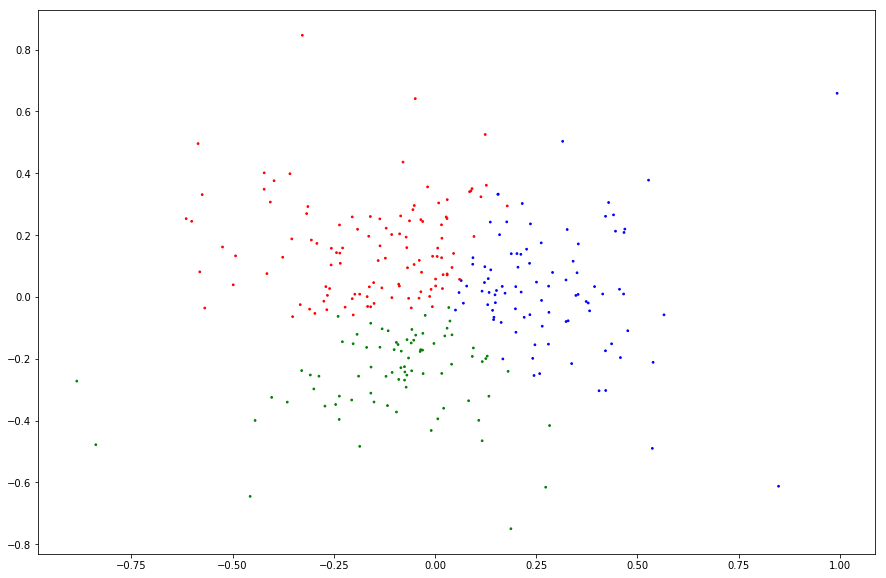

In [112]:
plt.figure(figsize=(15,10))

def visualiser(df, centres, affectation):
    """
    Sert à visualiser les clusters obtenus,
    utilise l'implémentation de l'algorithme PCA de scikit-learn.
    """
    nb_clusters = len(affectation)
    pca = PCA(n_components=2).fit(df)
    pca_2d = pca.transform(df)

    clusters = pca.transform(centres)
    colors = ['red','green','blue', 'black', 'grey', 'yellow', 'pink']
    col = []
    x = []
    y = []
    
    j=0
    for row in pca_2d:
        x.append(row[0])
        y.append(row[1])
        for i in range(nb_clusters):
            if j in affectation[i]:
                col.append(colors[i])
        j+=1
    plt.scatter(x, y, c=col, s=3, alpha=1)
    plt.show()

visualiser(DataFnorm, les_centres, l_affectation)